### Init

In [1]:
import os

import torch
import yaml
from PIL import Image

from grounded_sam import (run_grounded_sam_batch, transform_image_dino,
                          transform_image_sam)
from utils import resize_preserve_aspect_ratio

final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [2]:
def load_yaml(path):
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data


config_path = "configs/fashion_people.yml"
data = load_yaml(config_path)


def get_labels_dict(config_path):
    data = load_yaml(config_path)
    labels_dict = data.get("names")
    labels_dict = {v: k for k, v in labels_dict.items()}
    return labels_dict


device = "cuda"
config_path = "configs/fashion_people.yml"
data = load_yaml(config_path)
labels_dict = get_labels_dict(config_path)

### TEST

In [7]:
from datasets import load_dataset
import os 
repo_id = "jordandavis/fashion_people_detections"
workers = os.cpu_count()

# Load Dataset
ds = load_dataset(repo_id, split='train', streaming=True, trust_remote_code=True)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
from scripts.sam_results import SAMResults
from utils import (pad_to_fixed_size, resize_preserve_aspect_ratio, unload_box,
                   unload_mask)


def load_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_pil = resize_preserve_aspect_ratio(image_pil, 1024)
    image_pil = pad_to_fixed_size(image_pil, (1024, 1024))
    return image_pil


# image_dir = "datasets/person_seg/images/train"
# image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]
# image_paths = ["test_image_1.jpg", "test_image_2.jpg"]

# images = [load_image(image_path) for image_path in image_paths[:4]]
dino_images = torch.stack([transform_image_dino(image) for image in images])
sam_images = torch.stack([transform_image_sam(image) for image in images])

dino_images = dino_images.to(device)
sam_images = sam_images.to(device)

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [ ]:
labels_dict = get_labels_dict(config_path)
labels = [k for k in labels_dict.keys()]
text_prompt = " . ".join(labels)

In [ ]:
unformatted_results = run_grounded_sam_batch(dino_images, sam_images, text_prompt)

In [ ]:
r = SAMResults(images[1], labels_dict, **unformatted_results[1])
r.display_results()

In [ ]:
from utils import get_coco_style_polygons

In [ ]:
def get_masks_md(results):
    results_list = []
    for result in results.formatted_results:
        mask = result.get("mask")
        coco_polygons = get_coco_style_polygons(mask)

        # format the polygons
        result.update({"polygons": coco_polygons})
        result.pop("mask")
        results_list.append(result)
    return results_list

In [ ]:
unformatted_results[0]

In [ ]:
masks_md = []
image_ids = [0,1]
for image_id, image, raw_result in zip(image_ids, images, unformatted_results):
    if raw_result.get('masks') is None or ('person' not in raw_result.get("phrases")):
        # mask_md_row = dict(zip(str(image_id), [None]))
        mask_md = None
    else:
        result = SAMResults(image, labels_dict, **raw_result)
        mask_md = get_masks_md(result)

    # mask_metadata.update(mask_md_row)
    masks_md.append(mask_md)

In [ ]:
from utils import convert_coco_polygons_to_mask, overlay_mask

In [ ]:
type(polygons[0])

In [ ]:
polygons = masks_md[1][0]['polygons']
label = masks_md[1][0]['label']
image = images[1]
print(label)
mask = convert_coco_polygons_to_mask(polygons, 1024, 1024)

In [ ]:
mask.shape

In [ ]:
mask_image = Image.fromarray(mask)
overlay_mask(image, mask_image)

hair


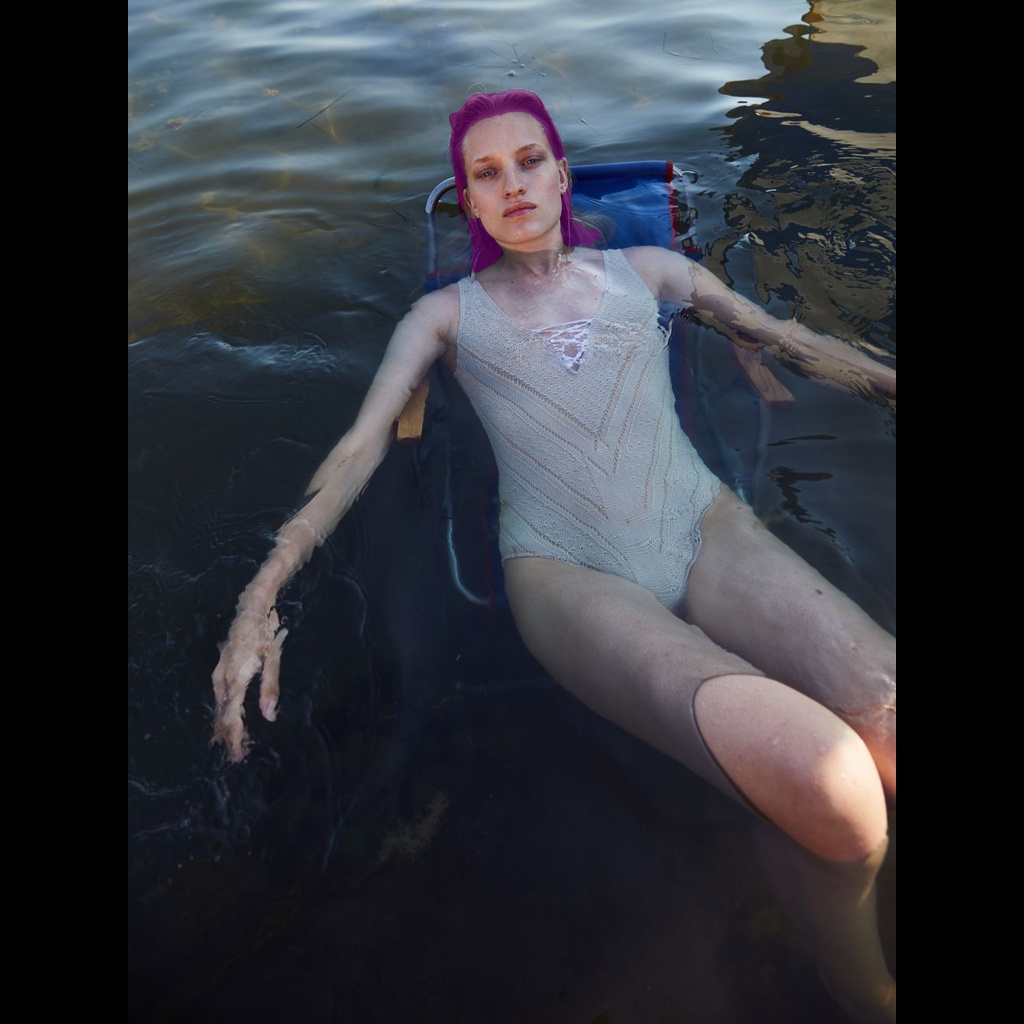

In [85]:
row = 102
mask_row = 2
ds_polygons = ds[row]['mask_metadata'][mask_row]['polygons']
ds_label = ds[row]['mask_metadata'][mask_row]['label']
image = ds[row]['image']
print(ds_label)
mask = convert_coco_polygons_to_mask(ds_polygons, 1024, 1024)
mask_image = Image.fromarray(mask)
overlay_mask(image, mask_image)

In [56]:
masks_md[1][0].keys()

dict_keys(['label', 'score', 'box', 'label_id', 'polygons'])

In [57]:
ds[1]['mask_metadata'][0].keys()

dict_keys(['box', 'label', 'label_id', 'polygons', 'score'])

In [65]:
len(ds_polygons[2])

12

In [71]:
labels = [row['label'] for row in ds[1]['mask_metadata']]
labels

['face', 'hair', 'person']

In [72]:
[r['label'] for r in masks_md[1]]

['face', 'hair', 'hand', 'leg', 'leg', 'neck', 'outfit', 'person']

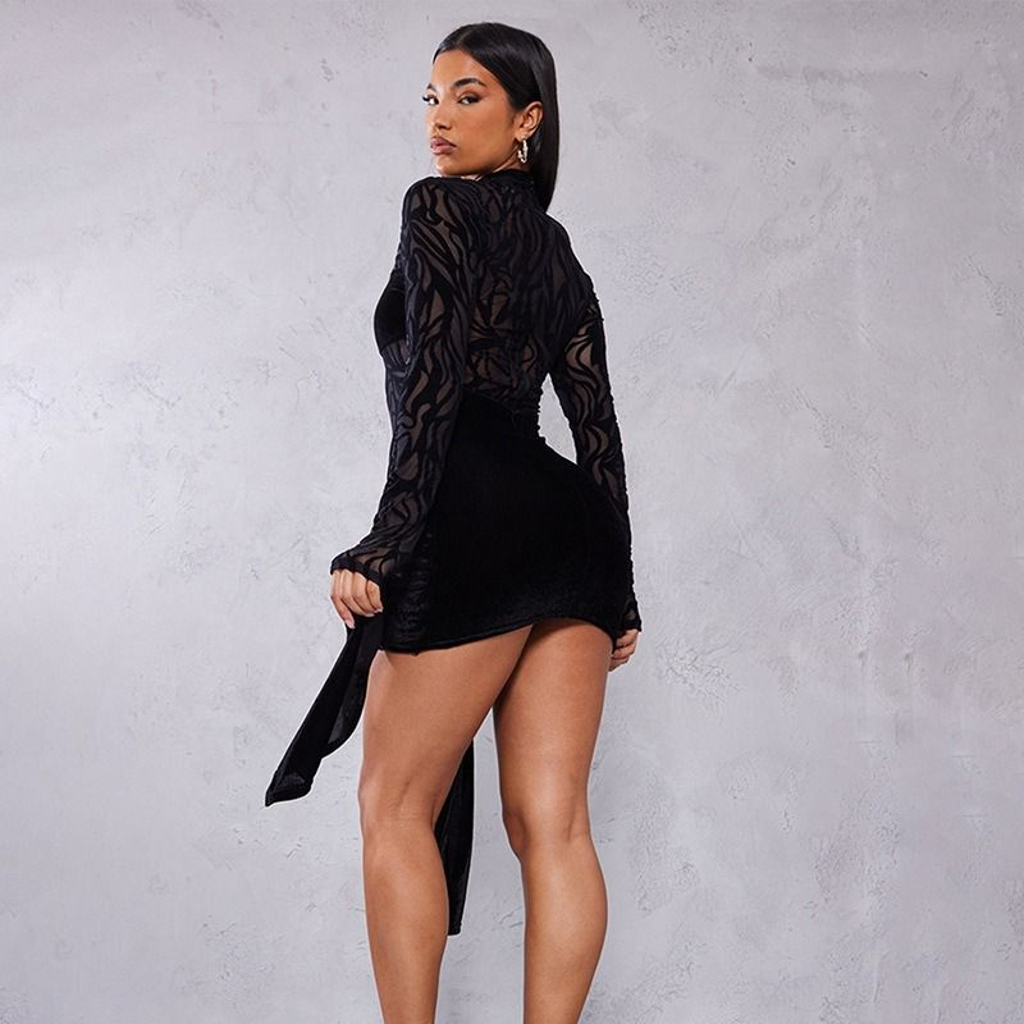

In [75]:
images[1]